In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from ast import literal_eval
import json
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import metrics
from scipy.special import boxcox, inv_boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import zscore
import pickle
from sklearn.linear_model import LinearRegression

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from sklearn.model_selection import cross_val_score, train_test_split
from fbprophet.plot import add_changepoints_to_plot

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

%matplotlib inline
# plt.style.use('fivethirtyeight')

Importing plotly failed. Interactive plots will not work.
Using TensorFlow backend.


In [2]:
# Postgres username, password, and database name
POSTGRES_ADDRESS = 'localhost'

POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'vegas'
POSTGRES_PASSWORD = 'VrichCrich99'
POSTGRES_DBNAME = 'univers-demo'

In [3]:
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME, password=POSTGRES_PASSWORD, ipaddress=POSTGRES_ADDRESS, port=POSTGRES_PORT, dbname=POSTGRES_DBNAME))
cnx = create_engine(postgres_str)

<h2 style='color: red; font-size: 2em'>Fetch user data according to data count</h2>

In [4]:
appstech_labs_id = 2 # user id for fetching

In [5]:
# define a fetching function according to the appstech_labs_user data size
def fetch_data(_id, small_data_size, medium_data_size, large_data_size):
    data_count = pd.read_sql_query(f"SELECT count(*) from user_sales_table where appstech_labs_id='{_id}'", cnx)
    data_count = int(data_count['count'][0])
    
    if data_count < small_data_size:
        return pd.read_sql_query(f"SELECT * FROM user_sales_table WHERE appstech_labs_id='{appstech_labs_id}'", cnx, index_col='date', parse_dates=['date'])
    
    elif data_count >= small_data_size and data_count < medium_data_size:
        return pd.read_sql_query(f"SELECT * FROM user_sales_table WHERE appstech_labs_id='{appstech_labs_id}' ORDER BY id DESC LIMIT {medium_data_size}", cnx, index_col='date', parse_dates=['date'])
    
    else:
        return pd.read_sql_query(f"SELECT * FROM user_sales_table WHERE appstech_labs_id='{appstech_labs_id}' ORDER BY id DESC LIMIT {large_data_size}", cnx, index_col='date', parse_dates=['date'])
        

In [6]:
df = fetch_data(appstech_labs_id, small_data_size=530234, medium_data_size=1530234, large_data_size=2203234)
df.index = pd.to_datetime(df.index)
df.head()

,id,appstech_labs_id,item_id,item_name,qty,unit_price,cost,net_amount,net_cost,currency,...,sub_total,margin,source,tax_inclusive_amount,sales_tax_rate,sales_tax_amount,gross_amount,customer_id,customer_name,sales_type
date,,,,,,,,,,,,,,,,,,,,,
2019-11-10,43659,2,2618,Plums,8.0,0.99,0.97,7.92,7.76,USD,...,7.52,-0.24,quickbooks,7.92,0.0,0.0,7.52,7.0,Rodney Hicks,sale
2019-12-06,44522,2,3656,Onion Powder,2.0,0.36,0.34,0.72,0.68,USD,...,0.66,-0.02,quickbooks,0.72,0.0,0.0,0.66,10.0,Ryan Nichols,sale
2019-12-23,45083,2,2119,Frosted Flakes,10.0,0.10,0.08,1.00,0.80,USD,...,0.97,0.17,quickbooks,1.00,0.0,0.0,0.97,3.0,Megan Weber,sale
2019-01-01,23570,2,2428,Deli Sliced Cheese (Muenster),10.0,0.22,0.20,2.20,2.00,USD,...,2.20,0.20,quickbooks,2.20,0.0,0.0,2.20,9.0,Ashley White,sale
2019-01-01,23571,2,3010,Raspberry Cream Bars,8.0,0.18,0.16,1.44,1.28,USD,...,1.41,0.13,quickbooks,1.44,0.0,0.0,1.41,10.0,Katherine Rose,sale


<h2 style='color: red; font-size: 2em'>Feature Engineering</h2>

In [7]:
def get_all_numeric_features(df):
    numeric_feats = df.dtypes[df.dtypes != 'object'].index
    numeric_feats = numeric_feats[1:]
    return numeric_feats

numeric_feats = get_all_numeric_features(df)
numeric_feats

Index(['appstech_labs_id', 'qty', 'unit_price', 'cost', 'net_amount',
       'net_cost', 'discount_rate', 'discount_amount', 'sub_total', 'margin',
       'tax_inclusive_amount', 'sales_tax_rate', 'sales_tax_amount',
       'gross_amount'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22143 entries, 2019-11-10 to 2019-12-31
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    22143 non-null  int64  
 1   appstech_labs_id      22143 non-null  int64  
 2   item_id               22143 non-null  object 
 3   item_name             22143 non-null  object 
 4   qty                   22143 non-null  float64
 5   unit_price            22143 non-null  float64
 6   cost                  22143 non-null  float64
 7   net_amount            22143 non-null  float64
 8   net_cost              22143 non-null  float64
 9   currency              22143 non-null  object 
 10  discount_rate         22143 non-null  float64
 11  discount_amount       22143 non-null  float64
 12  sub_total             22143 non-null  float64
 13  margin                21807 non-null  float64
 14  source                22143 non-null  object 
 15  ta

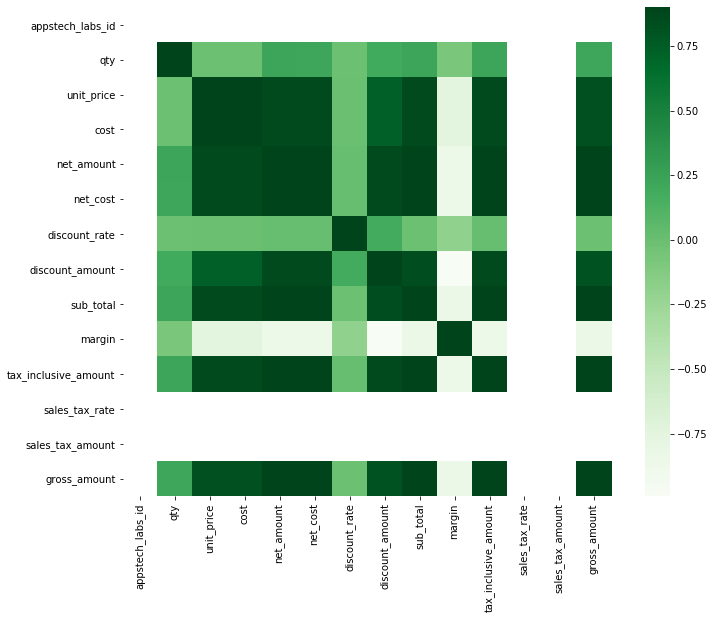

In [9]:
cormat = df[numeric_feats].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(cormat, vmax=0.9, square=True, cmap='Greens')
plt.show()

<h2 style='color: red; font-size: 2em'>Feature Importance</h2>

In [16]:
# feature importance
def feature_importance(features, df, threshold, *args, **kwargs):
    '''args, kwargs pass True or include=True for additional features'''
    important_feature = list()
    cormat = df[features].corr()
    
    if kwargs.get('include') or args:
        if kwargs.get('include') or args[0]:
            include = ['qty', 'margin']
            for expt in include:
                important_feature.append(expt)
    
    for feat in features:
        if cormat[f"{feat}"][-1] > threshold:
            important_feature.append(feat)
            
    return important_feature

In [17]:
imp_features = feature_importance(numeric_feats, df, 0.69, True)
df_feats = df.copy()
df_feats = df_feats[imp_features]
df_feats.head()

,qty,margin,unit_price,cost,net_amount,net_cost,discount_amount,sub_total,tax_inclusive_amount,gross_amount
date,,,,,,,,,,
2019-11-10,8.0,-0.24,0.99,0.97,7.92,7.76,0.40,7.52,7.92,7.52
2019-12-06,2.0,-0.02,0.36,0.34,0.72,0.68,0.06,0.66,0.72,0.66
2019-12-23,10.0,0.17,0.10,0.08,1.00,0.80,0.03,0.97,1.00,0.97
2019-01-01,10.0,0.20,0.22,0.20,2.20,2.00,0.00,2.20,2.20,2.20
2019-01-01,8.0,0.13,0.18,0.16,1.44,1.28,0.03,1.41,1.44,1.41


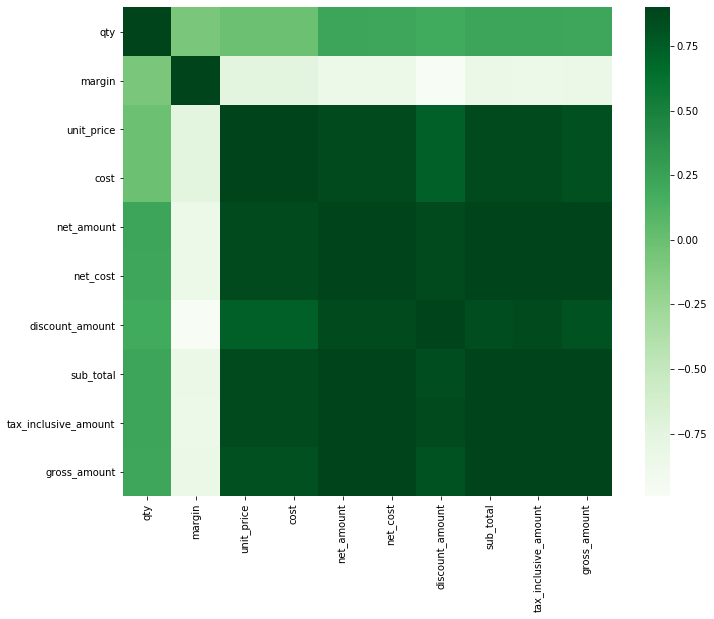

In [18]:
cormat = df_feats[imp_features].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(cormat, vmax=0.9, square=True, cmap='Greens')
plt.show()

<h2 style='color: red; font-size: 2em'>Check For Null Values</h2>

In [19]:
def generate_null_values(df, labels, target, model):
    data_with_null = df[labels].dropna()
    data_without_null = data_with_null.dropna()
    
    # all features except target
    train_data_x = data_without_null.drop(target, axis=1).values
    train_data_y = data_without_null[f"{target}"].values.reshape(-1, 1)
    
    model.fit(X=train_data_x, y=train_data_y) # training the model

    test_data = data_with_null.drop(target, axis=1) #
    yhat = model.predict(test_data)
        
    newdf = pd.DataFrame(yhat, columns=[target])
    # replace only the null values
    data_with_null[target].fillna(newdf[target], inplace=True)
    
    return data_with_null[target]
    
    
def handle_missing_value(df, features, *args, **kwargs):
    linreg = LinearRegression()
    
    if kwargs.get('drop_column'):
        return df.drop(features, axis=1)
    
    for feat in features:
        null_count = df[feat].isnull().sum()
        
        if null_count > 1 and null_count < int(len(df[feat]) * 10 / 100): # full missing values with mean()
            if df[feat].dtype == 'object':
                df[feat] = df[feat].fillna(df[feat].mode())
            else:
                df[feat] = df[feat].fillna(df[feat].mean())
            
        elif null_count >= int(len(df[feat]) * 10 / 100) and null_count < int(len(df[feat]) * 20 / 100): # random generate missing values
            technique = [df[feat].fillna(df[feat].mean()), df[feat].fillna(df[feat].median()), df[feat].fillna(df[feat].mode())]
            index = np.random.choice([0, 1, 2], p=[0.34, 0.33, 0.33])
            df[feat] = technique[index]
            
        elif null_count >= int(len(df[feat]) * 20 / 100) and null_count < int(len(df[feat]) * 40 / 100): # predict missing values if selected else random generate
            if kwargs.get('use_model') or args:
                if kwargs.get('use_model') or args[0]:
                    generate_null = generate_null_values(df, features, feat, linreg)
                    df[feat] = generate_null[~generate_null.index.duplicated()]
            else:
                technique = [df[feat].fillna(df[feat].mean()), df[feat].fillna(df[feat].median()), df[feat].fillna(df[feat].mode())]
                index = np.random.choice([0, 1, 2], p=[0.34, 0.33, 0.33])
                df[feat] = technique[index]
        
        elif null_count >= int(len(df[feat]) * 40 / 100): # worst case senario
            df = df.drop(feat, axis=1)
    
    return df


In [20]:
df_feats = handle_missing_value(df_feats, imp_features, True)
df_feats.isnull().sum()

qty                     0
margin                  0
unit_price              0
cost                    0
net_amount              0
net_cost                0
discount_amount         0
sub_total               0
tax_inclusive_amount    0
gross_amount            0
dtype: int64

<h2 style='color: red; font-size: 2em'>Target Engineering</h2>

In [21]:
# handle outliers
def handleOutliers(df, threshold):    
    z = np.abs(zscore(df))
    
    return df[(z < threshold).all(axis=1)]

In [22]:
df_feats_outliers = handleOutliers(df_feats, 3)
print(df_feats_outliers.shape)
df_feats_outliers.head()

(21362, 10)


,qty,margin,unit_price,cost,net_amount,net_cost,discount_amount,sub_total,tax_inclusive_amount,gross_amount
date,,,,,,,,,,
2019-11-10,8.0,-0.24,0.99,0.97,7.92,7.76,0.40,7.52,7.92,7.52
2019-12-06,2.0,-0.02,0.36,0.34,0.72,0.68,0.06,0.66,0.72,0.66
2019-12-23,10.0,0.17,0.10,0.08,1.00,0.80,0.03,0.97,1.00,0.97
2019-01-01,10.0,0.20,0.22,0.20,2.20,2.00,0.00,2.20,2.20,2.20
2019-01-01,8.0,0.13,0.18,0.16,1.44,1.28,0.03,1.41,1.44,1.41


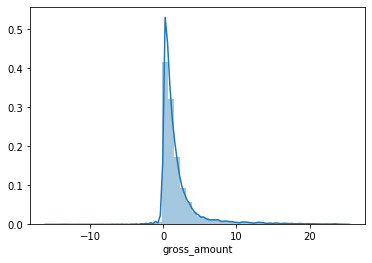

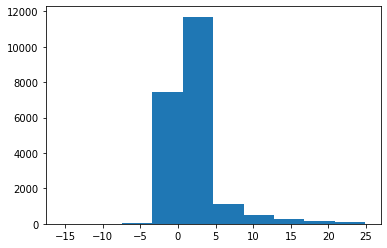

In [23]:
sns.distplot(df_feats_outliers['gross_amount'])
plt.show()
plt.hist(df_feats_outliers['gross_amount'])
plt.show()

In [26]:
LAMBDA = 2.5 # learning rate for scipy stats.

def normalize_value(df, features, norm_type, boxcox):
    return {
        "log1p_skew": np.log1p(df[features]), # inverse np.exp
        "sqrt_skew": np.sqrt(df[features]), # inverse x**-1/2
#         "stats_skew": boxcox(df[features], LAMBDA) # inverse inv_boxcox(state, 2.5)
    }.get(norm_type)


def inverser_normalize_value(df, features, norm_type, *args, **kwargs):
    return {
        "log1p_skew": np.exp(df[features]), # inverse np.exp
        "sqrt_skew": df[features] * df[features], # inverse x**-1/2
#         "stats_skew": inv_boxcox(df[features], kwargs.get("lambda")) # inverse inv_boxcox(state, 2.5)
    }.get(norm_type)

In [27]:
# data normalization for

def normalize_data(df, features, *arg, **kwargs):
    new_df = pd.DataFrame(columns=['features', 'log1p_skew', 'sqrt_skew']) #, 'stats_skew'
    
    for feat in features:
        try:
            sqrt = np.sqrt(df[feat])
            log1p = np.log1p(df[feat])
#             stats = pd.Series(boxcox(df[feat], LAMBDA))
        
        except ValueError:
#             stats = np.NaN
            pass
    
        new_df = new_df.append({'features': feat, 'log1p_skew': log1p.skew(), 'log1p_': log1p.isna().sum(), 'sqrt_skew': sqrt.skew(), 'sqrt_': sqrt.isna().sum()}, ignore_index=True)
#     'stats_skew': stats.skew(), 'stats_': stats.isna().sum(),

    new_df = new_df.groupby(['features']).sum()
    if new_df['log1p_'].values.sum() > 0:
        new_df = new_df.drop(['log1p_', 'log1p_skew'], axis=1)
    if new_df['sqrt_'].values.sum() > 0:
        new_df = new_df.drop(['sqrt_', 'sqrt_skew'], axis=1)
#     if new_df['stats_'].values.sum() > 0:
#         new_df = new_df.drop(['stats_', 'stats_skew'], axis=1)
        
    if new_df.empty:
        return None, df
    print(new_df)
    arg_norm_score_obj = list()
    for i in range(new_df.shape[1]):
        arg_norm_score_obj.append({"name": f"{new_df.columns[i]}", "score": new_df[f"{new_df.columns[i]}"].sum()})
        
    NORM_TYPE = min(i.get('name') for i in arg_norm_score_obj if i.get('score') > 0) # global variable ->>
    
    norm_val = normalize_value(df, features, NORM_TYPE, boxcox)
    return NORM_TYPE, norm_val


In [28]:
NORM_TYPE, df_feats_norm = normalize_data(df_feats_outliers, ['gross_amount'])
print(NORM_TYPE)
df_feats_norm.head()

None


,qty,margin,unit_price,cost,net_amount,net_cost,discount_amount,sub_total,tax_inclusive_amount,gross_amount
date,,,,,,,,,,
2019-11-10,8.0,-0.24,0.99,0.97,7.92,7.76,0.40,7.52,7.92,7.52
2019-12-06,2.0,-0.02,0.36,0.34,0.72,0.68,0.06,0.66,0.72,0.66
2019-12-23,10.0,0.17,0.10,0.08,1.00,0.80,0.03,0.97,1.00,0.97
2019-01-01,10.0,0.20,0.22,0.20,2.20,2.00,0.00,2.20,2.20,2.20
2019-01-01,8.0,0.13,0.18,0.16,1.44,1.28,0.03,1.41,1.44,1.41


In [29]:
# house_price = pd.read_csv('data/train.csv')
# print(house_price.shape)
# house_price = handle_missing_value(house_price, house_price.columns, True)
# house_price_outliers = handleOutliers(house_price[house_price.dtypes[house_price.dtypes != "object"].index], 3)
# NORM_TYPE_1, house_pricing_norm = normalize_data(house_price_outliers, house_price_outliers.columns) # global variable for NORM_TYPE ->>
# print(NORM_TYPE_1)
# house_pricing_norm.head()

<h1 style="color: red">Data spliting according to FBPROPHET model</h1>

In [77]:
# reshaping data for prophet model...

def generate_period(date, target):
    d = {"ds": date, "y": target.flatten()}
    return d

def data_reshaping_for_fbProphet(df, target, *args, **kwargs):
    try:
        # get period
        freq_ = kwargs.get('freq') if kwargs.get('freq') else 'D'     
        df = df.rename_axis('ds')        
        df = df.set_index(df.index).resample(freq_)[df.columns].sum()
        
        scaler_y = ''
        y = np.array(df[target].values).reshape(-1, 1)
        
        if kwargs.get("scaler"):
        # standardise target
            scaler_y = StandardScaler()
            y = scaler_y.fit_transform(y)
        
        df_frame = pd.DataFrame(data=generate_period(df.index, y))
        
        train = df_frame[:-131]
        test = df_frame[train.shape[0]:]
        return train, test, scaler_y
        
    except IndexError:
        raise(IndexError)
        

In [78]:
fb_train, fb_test, SCALER_PROPHET_Y = data_reshaping_for_fbProphet(df_feats_norm, 'gross_amount', freq="D", scaler=False)

In [79]:
print(fb_train.shape)
fb_train.head()

(235, 2)


,ds,y
0,2019-01-01,179.04
1,2019-01-02,136.25
2,2019-01-03,163.27
3,2019-01-04,146.76
4,2019-01-05,131.07


<h1 style="color: red">FB Model Prophet</h1>

In [80]:
model = Prophet(growth='linear', daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, changepoint_prior_scale=0.009) #instantiate Prophet
model.add_seasonality(name='monthyly', period=12, fourier_order=3, prior_scale=0.008) #add monthly seasonality
# model = Prophet()


model.fit(fb_train); #fit the model with your dataframe

future_data = model.make_future_dataframe(periods=len(fb_test), freq='D')

forecast = model.predict(future_data)

# fig = model.plot(forecast)
# a = add_changepoints_to_plot(fig.gca(), model, forecast)
# plt.show()

In [83]:
print(fb_test.shape, forecast['yhat'][len(fb_train) - len(future_data):].shape)
r2_score(fb_test['y'], forecast['yhat'][len(fb_train) - len(future_data):])

(131, 2) (131,)


-0.11492565296828938

In [85]:
print(len(future_data), len(fb_train), len(fb_test), len(fb_train)+len(fb_test))

366 235 131 366


<h1 style="color: red">Data spliting according to RNN model</h1>

In [44]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    
    return inverted[0, -1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    # reshape
    reshaped = X.reshape(len(X), 1, 1)
    # forecast dataset
    output = model.predict(reshaped, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i]
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
    
    return rmse


<h1 style="color: red">RNN LSTM MODEL WITHOUT ENCODER</h1>

In [45]:
# # # # LSTM for international airline passengers problem with regression framing
# import numpy
# import matplotlib.pyplot as plt
# from pandas import read_csv
# import math
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# # convert an array of values into a dataset matrix
# def create_dataset(X, y, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(X)-look_back-1):
#         a = X[i:(i+look_back), 0]
#         dataX.append(a)
#         dataY.append(y[i + look_back, 0])
#     return numpy.array(dataX), numpy.array(dataY)
# # fix random seed for reproducibility
# numpy.random.seed(7)
# # load the dataset
# # dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
# df_feats_norm = df_feats_norm.set_index(df_feats_norm.index).resample("D")[df_feats_norm.columns].sum()
# dataset = df_feats_norm.values
# dataset = dataset.astype('float32')

# # normalize the dataset
# scaler_x = MinMaxScaler(feature_range=(0, 1))
# scaler_y = MinMaxScaler(feature_range=(0, 1))
# # print(dataset[:, -1])
# X = scaler_x.fit_transform(dataset[:, :-1])
# y = scaler_y.fit_transform(dataset[:, -1].reshape(-1, 1))

# # split into train and test sets
# train_size = int(len(X) * 0.92)
# test_size = len(X) - train_size

# train_x, train_y = X[0:train_size, :], y[0:train_size]
# test_x, test_y = X[train_size:, :], y[train_size:]

# print(train_size, test_size)
# print(train_x.shape)
# print(train_y.shape)

# # reshape into X=t and Y=t+1
# look_back = 6
# trainX, trainY = create_dataset(train_x, train_y, look_back)
# testX, testY = create_dataset(test_x, test_y, look_back)
# # reshape input to be [samples, time steps, features]
# trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# print(trainX.shape, trainY.shape, testX.shape, testY.shape)
# # create and fit the LSTM network
# batch_size = 1
# model = Sequential()
# model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# for i in range(100):
#     model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
#     model.reset_states()
#     print(f'{i} done')
# # make predictions
# trainPredict = model.predict(trainX, batch_size=batch_size)
# model.reset_states()
# testPredict = model.predict(testX, batch_size=batch_size)
# # invert predictions
# trainPredict = scaler_y.inverse_transform(trainPredict)
# trainY = scaler_y.inverse_transform([trainY])
# testPredict = scaler_y.inverse_transform(testPredict)
# testY = scaler_y.inverse_transform([testY])
# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))
# # shift train predictions for plotting
# trainPredictPlot = numpy.empty_like(dataset)
# trainPredictPlot[:, :] = numpy.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = numpy.empty_like(dataset)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [46]:
# plot baseline and predictions
# plt.plot(dataset[:, -1])
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

In [59]:
# multivariate lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    
    n_start = 0
    for _ in range(len(sequences)):
        # find the end of this pattern
        end_ix = n_start + n_steps
        end_ox = end_ix + 30
        # check if we are beyond the dataset
        if end_ox > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[n_start:end_ix, :-1], sequences[end_ix:end_ox, -1]
        X.append(seq_x)
        y.append(seq_y)
        n_start += 1
    return array(X), array(y)

# horizontally stack columns
df_feats_norm = df_feats_norm.set_index(df_feats_norm.index).resample("D")[df_feats_norm.columns].sum()

dataset = df_feats_norm.values
# choose a number of time steps
train = dataset[:-90]
test = dataset[len(train):]

n_steps = 60
# convert into input/output
X, y = split_sequences(train, n_steps)

scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)

# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model

# model = Sequential()
# model.add(LSTM(10, activation='relu', input_shape=(X.shape[1], X.shape[2])))
# model.add(Dense(y.shape[1]))
# model.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit(X, y, epochs=200, verbose=1, batch_size=90)

batch_size = 1

model = Sequential()
model.add(LSTM(50, batch_input_shape=(batch_size, n_steps, X.shape[2]), stateful=True))
model.add(Dense(y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

# # demonstrate prediction
test_x, test_y = split_sequences(test, n_steps)
yhat = model.predict(test_x)

Epoch 1/1
187/187 [==============================] - 20s 107ms/step - loss: 0.1131
Epoch 1/1
187/187 [==============================] - 18s 95ms/step - loss: 0.0452
Epoch 1/1
187/187 [==============================] - 18s 96ms/step - loss: 0.0392
Epoch 1/1
187/187 [==============================] - 18s 98ms/step - loss: 0.0374
Epoch 1/1
187/187 [==============================] - 17s 90ms/step - loss: 0.0373
Epoch 1/1
187/187 [==============================] - 17s 93ms/step - loss: 0.0373
Epoch 1/1
187/187 [==============================] - 19s 102ms/step - loss: 0.0373
Epoch 1/1
187/187 [==============================] - 19s 101ms/step - loss: 0.0373
Epoch 1/1
187/187 [==============================] - 18s 96ms/step - loss: 0.0373
Epoch 1/1
187/187 [==============================] - 26s 141ms/step - loss: 0.0373
Epoch 1/1
187/187 [==============================] - 33s 177ms/step - loss: 0.0373
Epoch 1/1
187/187 [==============================] - 31s 164ms/step - loss: 0.0373
Epoch 1/1


In [60]:
print(test_y.shape)
print(yhat.shape)

(1, 30)
(1, 30)


In [61]:
# r2_score(test_y.reshape(-1, 1), yhat.reshape(-1, 1))
r2_score(test_y.reshape(-1, 1), scaler.inverse_transform(yhat).reshape(-1, 1))

-5.3607832567456475

In [62]:
scaler.inverse_transform(yhat)[0]
# yhat[0]

array([109.17986 , 122.40181 ,  71.032936, 110.96112 ,  87.61354 ,
       110.7427  ,  94.73226 ,  82.327484,  78.54214 ,  69.083115,
       125.42903 , 109.339355, 103.60989 , 163.72975 , 133.28474 ,
       137.05775 , 113.45038 , 141.8398  , 124.56232 , 131.9972  ,
       120.701385, 127.75624 , 140.35135 , 115.341484,  62.240234,
       114.15033 , 112.0193  , 130.45184 , 148.55592 , 108.799675],
      dtype=float32)

In [63]:
test_y

array([[ 24.64,  61.69,  53.35,  44.62,  56.04,  61.78,  38.16,  88.21,
         70.95, 100.05,  70.56,  69.07,  51.7 ,  78.34,  62.66,  58.57,
         53.23,  53.14,  39.8 ,  70.5 ,  92.26,  62.45, 107.56,  55.29,
         51.15,  77.34, 118.73,  78.91,  65.41,   1.06]])

In [ ]:
# univariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
 
# split a univariate dataset into train/test sets
def split_dataset(data, look_back):
    # split into standard weeks
    print(data.shape)
    train, test = data[:-30], data[-30:]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/1))
    test = array(split(test, len(test)/1))
    print(train.shape)
    return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=1):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)
 
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model
 
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat
 
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores
 
# # load the new file
df_feats_norm = df_feats_norm.set_index(df_feats_norm.index).resample("D")[df_feats_norm.columns].sum()
dataset = df_feats_norm
# # split into train and test
# train, test = split_dataset(dataset.values, 30)
# # evaluate model and get scores
# n_input = 14
# score, scores = evaluate_model(train, test, n_input)
# # summarize scores
# summarize_scores('lstm', score, scores)
# # plot scores
# days = ['day']
# pyplot.plot(days, scores, marker='o', label='lstm')
# pyplot.show()